In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wrangle
from sklearn.model_selection import train_test_split
from scipy import stats

plt.rcParams['figure.figsize'] = [12,8]
alpha = .05

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import sklearn.preprocessing

### Project Planning
- Audience: potential consumers planning airline travel.
- Utilize classification modeling to determine how long a flight will be delayed by categories.
- Find key features that drive flight delays.

**Initial Hypothesis**
- Ariline carriers will impact the amount of time delayed.
- Departure and arrival airports will impact the amount of time delayed.
- Day of the week will impact the amount of time delayed.
- The time of the year(month) will impact the amount of time delayed.
- The time of the scheduled flight will impact the amount of time delayed.


### Executive Summary
- Key drivers of flight delays are:
    - Month, DayOfWeek, DayofMonth, CRSElapsedTime, AirTime, departure_hour
- Best performing classification model:
    - Gradient Boosting
    - Test was in-line with baseline, but did not out perform.
    - Predictions can be found in prediction.csv.
- The category with the highest occurence is category one: 15-59 minutes delayed.
    

### Acquire

- Data was acquired from [kaggle](https://www.kaggle.com/datasets/giovamata/airlinedelaycauses?select=DelayedFlights.csv), with the original datset coming from the U.S. Department of Transportation - Bureau of Transportation Satistics.

- Comprised of airline data from January to December 2008.

#### What's in the data?
- **Delayed_Status:**(Target Variable) categorical groups depedning on length of delay. 
    - 0: No delay
    - 1: Delay from 16-59 minutes
    - 2: Delay from 60-119 minuutes
    - 3: Delay from 120- 179 minutes
    - 4: Delay greater than 180 minutes
- **Year:** 2008
- **Month:** 1-12
- **DayofMonth:** 1-31
- **DayOfWeek:** 1 (Monday) - 7 (Sunday)
- **CRSDepTime:** scheduled departure time (local, hhmm)
- **CRSArrTime:** scheduled arrival time (local, hhmm)
- **UniqueCarrier:** unique carrier code
- **TailNum:** plane tail number: aircraft registration, unique aircraft identifier
- **CRSElapsedTime:** in minutes
- **AirTime:** in minutes
- **ArrDelay:** arrival delay, in minutes: A flight is counted as "on time" if it arrived less than 15 minutes before the carriers' scheduled Computerized Reservations Systems (CRS) time.
- **Origin:** origin IATA airport code
- **Dest:** destination IATA airport code
- **Distance** in miles
- **CarrierDelay in minutes:** The cause of the cancellation or delay was due to circumstances within the airline's control (e.g. maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.).
- **WeatherDelay in minutes:** Significant meteorological conditions (actual or forecasted) that, in the judgment of the carrier, delays or prevents the operation of a flight such as tornado, blizzard or hurricane.
- **NASDelay in minutes:** Delays and cancellations attributable to the national aviation system that refer to a broad set of conditions, such as non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control.
- **LateAircraftDelay in minutes:** A previous flight with same aircraft arrived late, causing the present flight to depart late.
- **SecurityDelay in minutes:** Delays or cancellations caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
- **Delayed:** If a flight has been delayed or not.
- **departure_hour:** The 24 hour that the flight was scheduled to depart.


In [2]:
df = wrangle.get_flight_data()
df.head(1)

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN


### Prepare

- Original data comprised of 1,936,758 rows and 30 columns.
- Data preparation included:
    - Dropping nulls.
    - Dropping duplicate columns(example:CRSArrTime vs ArrTime).
    - Converts floats to integers.
    - Created Delayed, Delayed_Status, and departure_hour.
    - One-hot encoded UniqueCarrier.
    - Converted CRSDepTime to 24 hour datetime.time.
    - Limited airlines to: WN|AA|MQ|UA|OO|DL
    - Limited airports to: ATL|DFW|DEN|LAX
    
- Dataframe now consists of 12,846 rows and 27 columns.

In [3]:
df = wrangle.prepare_flight_data(df)
df.head(1)

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,TailNum,CRSElapsedTime,AirTime,...,NASDelay,SecurityDelay,LateAircraftDelay,Delayed_Status,Delayed,UniqueCarrier_DL,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_WN,departure_hour
51640,2008,1,1,2,14:29:00,1922,OO,N772SK,173,153,...,0,0,0,0,0,0,1,0,0,14


#### Train, validate, test split

In [4]:
train, validate, test = wrangle.split_flight_data(df)

In [5]:
train.shape, validate.shape, test.shape

((7193, 27), (3083, 27), (2570, 27))

### Explore

**Questions to ask**
- Does the airline impact flight delays?
- Does the airport impact flight delays?
     - Departure and Arrival
- Does the day of the week impact flight delays?
- Does the month impact flight delays?
- Does the time the flight was schedule to depart impact flight delays?

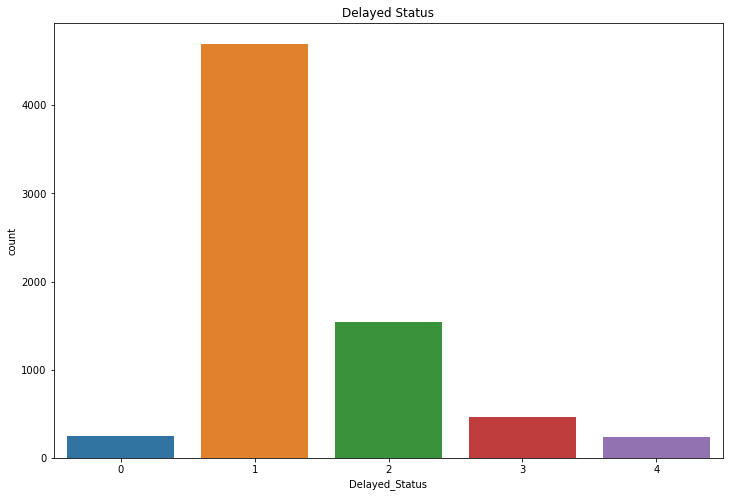

In [6]:
sns.countplot(train.Delayed_Status)
plt.title('Delayed Status')
plt.show()

View distribution of the target variable.
- The majority of delays are greater than 15 minutes but less than 59 minutes.


### Does the Airline impact flight delays?

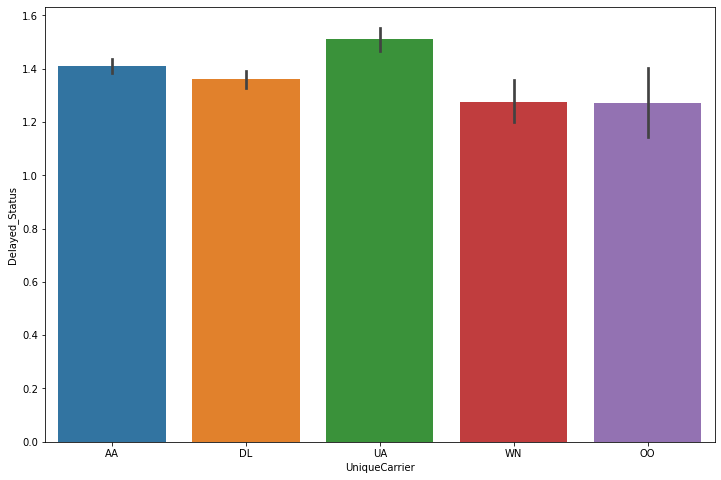

In [7]:
sns.barplot(data=train, x = 'UniqueCarrier', y = 'Delayed_Status')
plt.show()

**Notes:** There is a visual indication that there is variability in the mean delayed status per airline, with United having the highest mean delayed status.

In [8]:
# create dataframes for each unique airline
AA = train[train.UniqueCarrier =='AA']
DL = train[train.UniqueCarrier =='DL']
UA = train[train.UniqueCarrier =='UA']
OO = train[train.UniqueCarrier =='OO']
WN = train[train.UniqueCarrier =='WN']

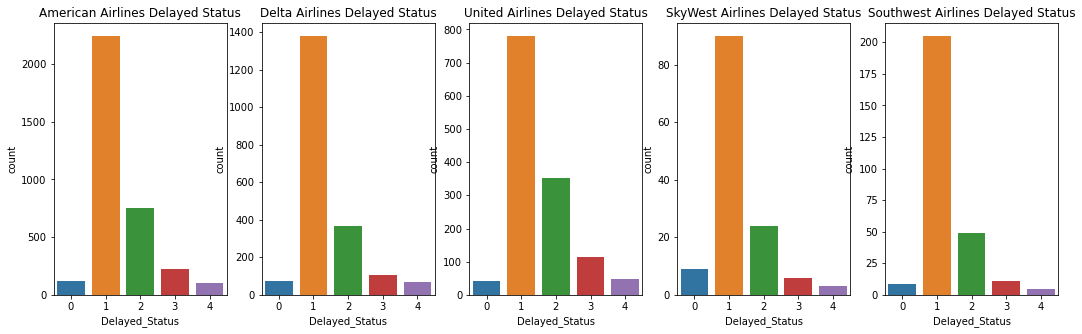

In [9]:
# visualuze the unique airlines with their specific delayed statuses
plt.figure(figsize=(18,5))
plt.subplot(151)
sns.countplot(data=AA, x='Delayed_Status')
plt.title('American Airlines Delayed Status')

plt.subplot(152)
sns.countplot(data=DL, x='Delayed_Status')
plt.title('Delta Airlines Delayed Status')

plt.subplot(153)
sns.countplot(data=UA, x='Delayed_Status')
plt.title('United Airlines Delayed Status')

plt.subplot(154)
sns.countplot(data=OO, x='Delayed_Status')
plt.title('SkyWest Airlines Delayed Status')

plt.subplot(155)
sns.countplot(data=WN, x='Delayed_Status')
plt.title('Southwest Airlines Delayed Status')
plt.show()

**Notes:** Delayed status 1 looks uniform throughout the airlines, while status 2 (60-179 minite delay shows variability and United Airlines shows a greater distribution of flights within the delayed status 3 category.

**Next Steps: perform chi squared testing**

- Null Hypothesis: Delayed status and Airline are independent.
- Alternative Hypothesis: Delayed status and Airline are dependent.


In [10]:
observed = pd.crosstab(train.Delayed_Status, train.UniqueCarrier)

In [11]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

1.7969244654332686e-08

In [12]:
if p < alpha:
    print("Reject the null")
else:
    print('Fail to reject the null')

Reject the null


**Answer to question:** There is a relationship between airlines and flight delays.

### Does the airport impact flight delays?

#### Departing airport (Origin)

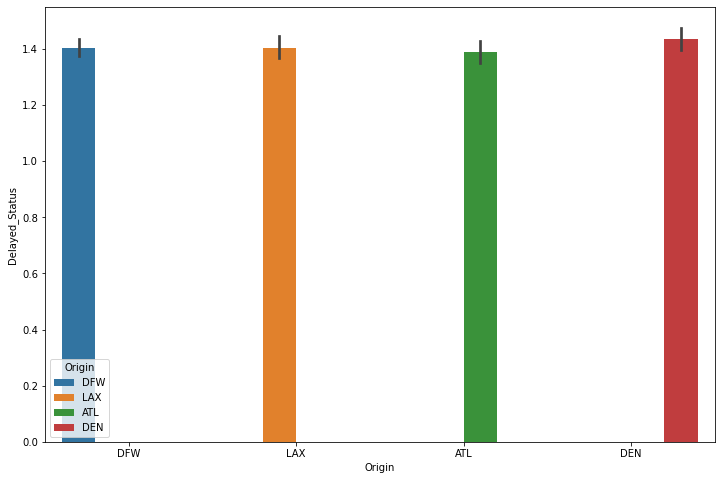

In [13]:
sns.barplot(data=train, y=train.Delayed_Status, x=train.Origin, hue=train.Origin)
plt.show()

In [14]:
DFW = train[train.Origin =='DFW']
LAX = train[train.Origin =='LAX']
ATL = train[train.Origin =='ATL']
DEN = train[train.Origin =='DEN']

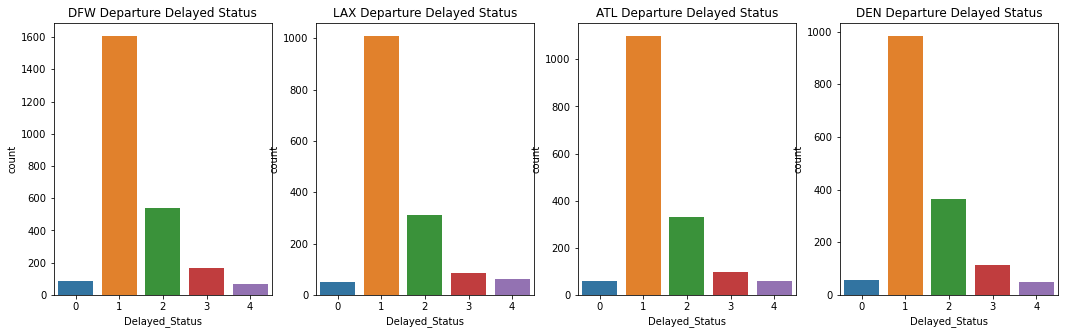

In [15]:
plt.figure(figsize=(18,5))
plt.subplot(141)
sns.countplot(data=DFW, x='Delayed_Status')
plt.title('DFW Departure Delayed Status')

plt.subplot(142)
sns.countplot(data=LAX, x='Delayed_Status')
plt.title('LAX Departure Delayed Status')

plt.subplot(143)
sns.countplot(data=ATL, x='Delayed_Status')
plt.title('ATL Departure Delayed Status')

plt.subplot(144)
sns.countplot(data=DEN, x='Delayed_Status')
plt.title('DEN Departure Delayed Status')
plt.show()

**Notes:** Departure airports don't seem to have too much variability between them, possibly in delayed status 3 and 4. DFW has more flights departing than the other airports.

**Next Steps: perform chi squared testing**

- Null Hypothesis: Delayed status and takeoff location are independent.
- Alternative Hypothesis: Delayed status and takeoff location are dependent.


In [16]:
observed = pd.crosstab(train.Delayed_Status, train.Origin)

In [17]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

0.10732864876528733

In [18]:
if p < alpha:
    print("Reject the null")
else:
    print('Fail to reject the null')

Fail to reject the null


#### Arrival airport (Dest)

In [19]:
DFW_d = train[train.Dest =='DFW']
LAX_d = train[train.Dest =='LAX']
ATL_d = train[train.Dest =='ATL']
DEN_d = train[train.Dest =='DEN']

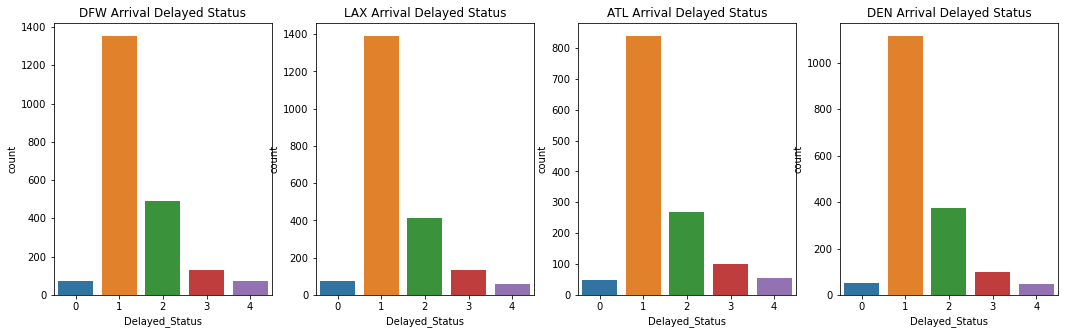

In [20]:
plt.figure(figsize=(18,5))
plt.subplot(141)
sns.countplot(data=DFW_d, x='Delayed_Status')
plt.title('DFW Arrival Delayed Status')

plt.subplot(142)
sns.countplot(data=LAX_d, x='Delayed_Status')
plt.title('LAX Arrival Delayed Status')

plt.subplot(143)
sns.countplot(data=ATL_d, x='Delayed_Status')
plt.title('ATL Arrival Delayed Status')

plt.subplot(144)
sns.countplot(data=DEN_d, x='Delayed_Status')
plt.title('DEN Arrival Delayed Status')
plt.show()

**Notes:** The arrival airports are visualy showing similar distibutions through all four airports.

**Next Steps: perform chi squared testing**

- Null Hypothesis: Delayed status and arrival location are independent.
- Alternative Hypothesis: Delayed status and arrival location are dependent.

In [21]:
observed = pd.crosstab(train.Delayed_Status, train.Dest)

In [22]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

0.10829858413351334

In [23]:
if p < alpha:
    print("Reject the null")
else:
    print('Fail to reject the null')

Fail to reject the null


**Answer to question:** Delayed status and airport arrival/departure locations are independent.

### Does the day of the week impact flight delays?

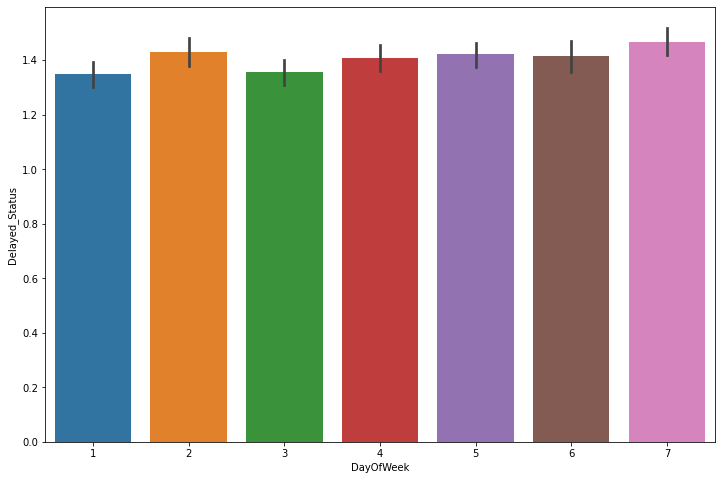

In [24]:
sns.barplot(data=train, x=train.DayOfWeek, y=train.Delayed_Status)
plt.show()

**Notes:** Tuesday and Sunday show the highest mean delayed status, with Monday and Wednesday being the lowest. Thursday, Friday, and Saturday seem to be in line with each other.

In [25]:
mon=train[train.DayOfWeek==1]
tue=train[train.DayOfWeek==2]
wed=train[train.DayOfWeek==3]
thur=train[train.DayOfWeek==4]
fri=train[train.DayOfWeek==5]
sat=train[train.DayOfWeek==6]
sun=train[train.DayOfWeek==7]

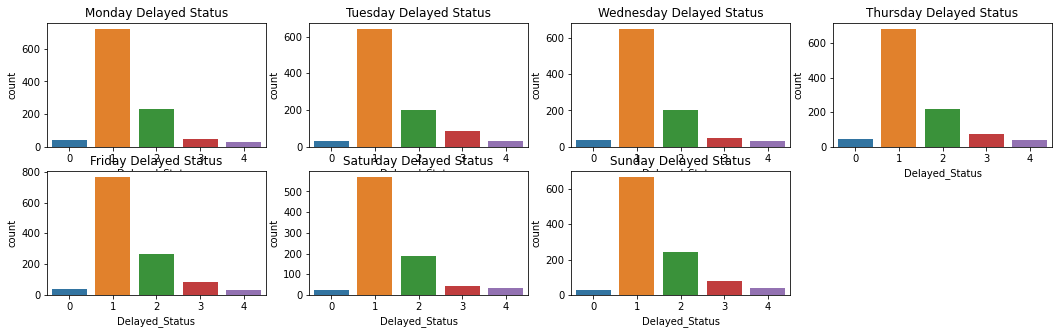

In [26]:
# plot delayed status per day of the week
plt.figure(figsize=(18,5))
plt.subplot(241)
sns.countplot(data=mon, x='Delayed_Status')
plt.title('Monday Delayed Status')

plt.subplot(242)
sns.countplot(data=tue, x='Delayed_Status')
plt.title('Tuesday Delayed Status')

plt.subplot(243)
sns.countplot(data=wed, x='Delayed_Status')
plt.title('Wednesday Delayed Status')

plt.subplot(244)
sns.countplot(data=thur, x='Delayed_Status')
plt.title('Thursday Delayed Status')

plt.subplot(245)
sns.countplot(data=fri, x='Delayed_Status')
plt.title('Friday Delayed Status')

plt.subplot(246)
sns.countplot(data=sat, x='Delayed_Status')
plt.title('Saturday Delayed Status')

plt.subplot(247)
sns.countplot(data=sun, x='Delayed_Status')
plt.title('Sunday Delayed Status')
plt.show()



**Notes:** This visualization doesn't show too much variability other than Tuesday's Delay status 3. Saturday has less flights than the other days, and Friday has the most, as indicated by the axis.


**Next Steps: perform chi squared testing**

- Null Hypothesis: Delayed status and day of the week are independent.
- Alternative Hypothesis: Delayed status and day of the week are dependent.

In [27]:
observed = pd.crosstab(train.Delayed_Status, train.DayOfWeek)

In [28]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

0.02563956820010972

In [29]:
if p < alpha:
    print("Reject the null")
else:
    print('Fail to reject the null')

Reject the null


**Answer to question:** There is a relationship between day of the week and delayed status.

### Does the time of the year impact flight delays? (month)

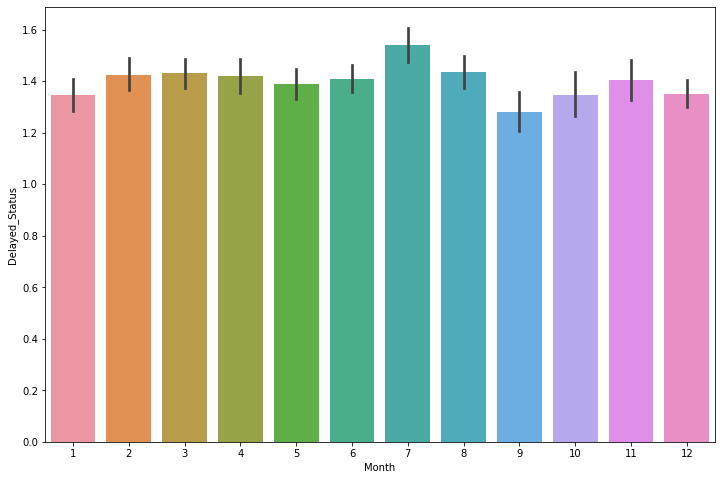

In [30]:
sns.barplot(data=train, x=train.Month, y=train.Delayed_Status)
plt.show()

**Notes:** Visually, variabity between months and delayed status is evident with July having the highest average delayed status.

**Next Steps: perform chi squared testing**

- Null Hypothesis: Delayed status and month are independent.
- Alternative Hypothesis: Delayed status and month are dependent.

In [31]:
observed = pd.crosstab(train.Delayed_Status, train.Month)

In [32]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

8.145267866834006e-05

In [33]:
if p < alpha:
    print("Reject the null")
else:
    print('Fail to reject the null')

Reject the null


**Answer to question:** There is a relationship between the month and delayed status.

### Does the day of the month impact flight delays?

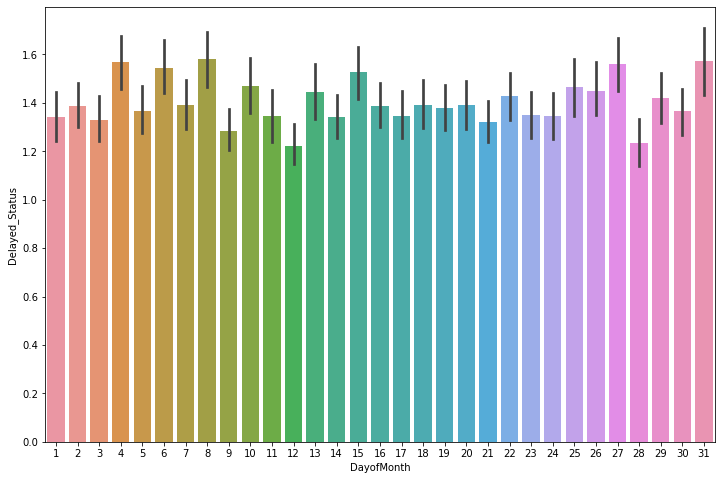

In [34]:
sns.barplot(data=train, x=train.DayofMonth, y=train.Delayed_Status)
plt.show()

**Notes:** Visually, variability is evident over the days of the month.

**Next Steps: perform chi squared testing**

- Null Hypothesis: Delayed status and day of the month are independent.
- Alternative Hypothesis: Delayed status and day of the month are dependent.

In [35]:
observed = pd.crosstab(train.Delayed_Status, train.DayofMonth)

In [36]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

4.3358342374987734e-07

In [37]:
if p < alpha:
    print("Reject the null")
else:
    print('Fail to reject the null')

Reject the null


**Answer to question:** There is a relationship between day of the month and delayed status.

### Does the scheduled departure time impact flight delays?

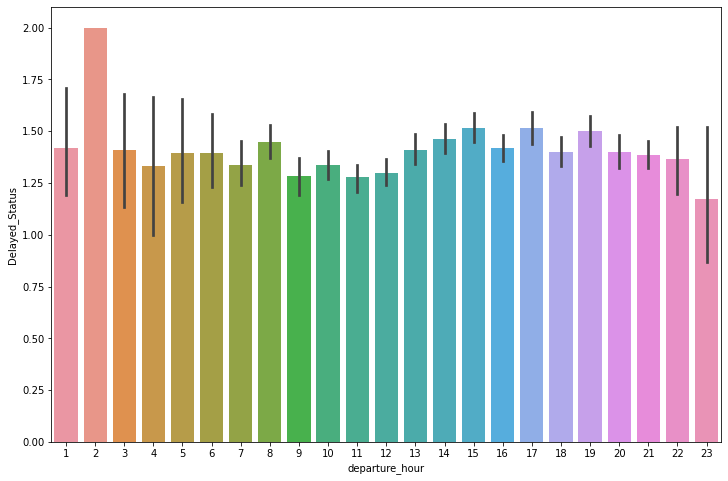

In [38]:
sns.barplot(data=train, y= 'Delayed_Status', x='departure_hour')
plt.show()

**Notes:** Visualization shows variability between the average delayed status and the scheduled hour of the departure. With 2AM being a problematic area.

**Next Steps: perform chi squared testing**

- Null Hypothesis: Delayed status and the scheduled departure hour are independent.
- Alternative Hypothesis: Delayed status and the scheduled departure hour are dependent.

In [39]:
observed = pd.crosstab(train.Delayed_Status, train.departure_hour)

In [40]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

1.1750329775978126e-06

In [41]:
if p < alpha:
    print("Reject the null")
else:
    print('Fail to reject the null')

Reject the null


**Answer to question:** There is a relationship between the scheduled departure time and delayed status.

**Review of exploration:**
Of the features chosen, all have a relationship with delayed status outside of the airport location.

#### Scale the train, validate, test datasets

In [42]:
train_scaled, validate_scaled, test_scaled = wrangle.scale_data(train,test,validate)

### Modeling

- Initial features include all in the datframe except for the following:
    - CRSDepTime - accounted for as departure_hour
    - CRSArrTime
    - UniqueCarrier - one-hot encoded
    - TailNum 
    - ArrDelay, DepDelay, CarrierDelayWeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay,
      Delayed_Status, Delayed (due to data leakage)

In [43]:
X_train = train_scaled.drop(columns=['CRSDepTime', 'CRSArrTime',
       'UniqueCarrier', 'TailNum','ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'Delayed_Status','Delayed'])
y_train = train_scaled.Delayed_Status

X_validate = validate_scaled.drop(columns=['CRSDepTime', 'CRSArrTime',
       'UniqueCarrier', 'TailNum','ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'Delayed_Status','Delayed'])
y_validate = validate_scaled.Delayed_Status

X_test = test_scaled.drop(columns=['CRSDepTime', 'CRSArrTime',
       'UniqueCarrier', 'TailNum','ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'Delayed_Status','Delayed'])
y_test = test_scaled.Delayed_Status

### Baseline Prediction

In [44]:
# determine the baseline
train.Delayed_Status.mode()

0    1
dtype: int64

In [45]:
baseline_prediction = (y_train == 1)

baseline_accuracy = baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.65


**With the assumption that every flight will be delayed from 15 to 59 minutes, the baseline is 65% accurate.**

### Decision Tree

In [46]:
metrics = []

for i in range(2, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.653135,0.661868,-0.008733
1,3,0.653135,0.661868,-0.008733
2,4,0.653691,0.661868,-0.008177
3,5,0.658279,0.659922,-0.001643
4,6,0.663979,0.657198,0.006780
5,7,0.671069,0.651751,0.019318
6,8,0.681079,0.641245,0.039834
7,9,0.696093,0.635019,0.061074
8,10,0.711803,0.629961,0.081842
9,11,0.732796,0.613619,0.119177


In [47]:
# create the model
clf = DecisionTreeClassifier(max_depth=5, random_state=123)

In [48]:
# fit the model
clf = clf.fit(X_train, y_train)

In [49]:
# make prediction on train obeservations
y_pred = clf.predict(X_train)

In [50]:
# plot_tree(clf, feature_names=X_train.columns, class_names = clf.classes_.astype(str), rounded=True)

In [51]:
y_pred_proba = clf.predict_proba(X_train)

In [52]:
print('Accuracy on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy on training set: 0.66


In [53]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       250
           1       0.66      0.99      0.79      4698
           2       0.53      0.06      0.12      1547
           3       1.00      0.00      0.00       464
           4       0.00      0.00      0.00       234

    accuracy                           0.66      7193
   macro avg       0.44      0.21      0.18      7193
weighted avg       0.61      0.66      0.54      7193



In [54]:
print('Accuracy on training set: {:.2f}'
      .format(clf.score(X_validate, y_validate)))

Accuracy on training set: 0.66


In [55]:
# Produce y_predictions that come from the X_validate
y_pred = clf.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.67      0.98      0.79      1701
           2       0.40      0.04      0.07       556
           3       0.00      0.00      0.00       155
           4       0.00      0.00      0.00        81

    accuracy                           0.66      2570
   macro avg       0.21      0.20      0.17      2570
weighted avg       0.53      0.66      0.54      2570



**Decision tree modeling is making predictions on three out of the five categories with in-sample data and then only predicts on two categories in the validation dataset.**

### Random Forrests

In [56]:
metrics = []

for i in range(2, 25):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.653135,0.661868,-0.008733
1,3,0.653135,0.661868,-0.008733
2,4,0.653135,0.661868,-0.008733
3,5,0.653135,0.661868,-0.008733
4,6,0.653135,0.661868,-0.008733
5,7,0.653969,0.661868,-0.007899
6,8,0.657862,0.662646,-0.004784
7,9,0.663423,0.663035,0.000388
8,10,0.673989,0.665370,0.008619
9,11,0.693591,0.664981,0.028610


**A max-depth of 10 produces the best validation results with a minimal difference between in and out-of sample data.

In [57]:
# create the model
rf = RandomForestClassifier(max_depth=10, 
                            random_state=123)

In [58]:
# fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=123)

In [59]:
y_pred = rf.predict(X_train)

In [60]:
y_pred_proba = rf.predict_proba(X_train)

In [61]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.67


In [62]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02       250
           1       0.67      1.00      0.80      4698
           2       0.99      0.09      0.16      1547
           3       0.91      0.02      0.04       464
           4       1.00      0.01      0.03       234

    accuracy                           0.67      7193
   macro avg       0.91      0.23      0.21      7193
weighted avg       0.78      0.67      0.56      7193



In [63]:
y_pred = rf.predict(X_validate)

In [64]:
y_pred_proba = rf.predict_proba(X_validate)

In [65]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.66      1.00      0.80      1701
           2       0.83      0.02      0.04       556
           3       0.00      0.00      0.00       155
           4       0.00      0.00      0.00        81

    accuracy                           0.67      2570
   macro avg       0.30      0.20      0.17      2570
weighted avg       0.62      0.67      0.54      2570



In [66]:
print(rf.feature_importances_)

[0.         0.1207261  0.17735338 0.10401699 0.15658427 0.21644088
 0.03723673 0.01476801 0.0087198  0.01918702 0.00605355 0.13891327]


In [67]:
X_train.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime', 'AirTime',
       'Distance', 'UniqueCarrier_DL', 'UniqueCarrier_OO', 'UniqueCarrier_UA',
       'UniqueCarrier_WN', 'departure_hour'],
      dtype='object')

**Random forrests modeling is making predictions on all five categories with in-sample data and then only predicts on two categories in the validation dataset. Precision is higher on category 2 than category 1, which is the only category the baseline model is predicting on.**
- Based on feature importance, I need to look into tweaking which features to model on.

### K-Nearest Neighbors

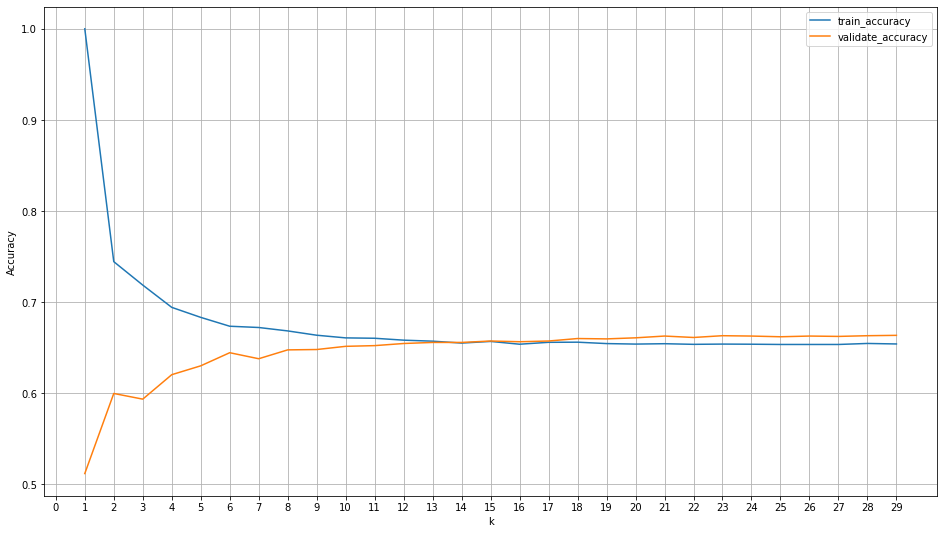

In [68]:
metrics = []

# loop through different values of k
for k in range(1, 30):
            
    # define the thing
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # fit the thing (remmeber only fit on training data)
    knn.fit(X_train, y_train)
    
    # use the thing (calculate accuracy)
    train_accuracy = knn.score(X_train, y_train)
    validate_accuracy = knn.score(X_validate, y_validate)
    
    output = {
        "k": k,
        "train_accuracy": train_accuracy,
        "validate_accuracy": validate_accuracy
    }
    
    metrics.append(output)

# make a dataframe
results = pd.DataFrame(metrics)

# plot the data
results.set_index('k').plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,30,1))
plt.grid()

**Validate accuracy is highest at neighbors 21, with a small increase in accuracy from in-sample to out-of-sample data.**

In [69]:
knn = KNeighborsClassifier(n_neighbors=21)

In [70]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=21)

In [71]:
y_pred = knn.predict(X_train)

In [72]:
y_pred_proba = knn.predict_proba(X_train)

In [73]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.65


In [74]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       250
           1       0.66      1.00      0.79      4698
           2       0.43      0.02      0.04      1547
           3       0.00      0.00      0.00       464
           4       0.00      0.00      0.00       234

    accuracy                           0.65      7193
   macro avg       0.22      0.20      0.17      7193
weighted avg       0.52      0.65      0.52      7193



In [75]:
y_pred = knn.predict(X_validate)

In [76]:
y_pred_proba = knn.predict_proba(X_validate)

In [77]:
print('Accuracy of KNN classifier on validate set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on validate set: 0.66


In [78]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.66      0.99      0.80      1701
           2       0.48      0.02      0.04       556
           3       0.00      0.00      0.00       155
           4       0.00      0.00      0.00        81

    accuracy                           0.66      2570
   macro avg       0.23      0.20      0.17      2570
weighted avg       0.54      0.66      0.54      2570



**KNN modeling is making predictions on two out of the five categories with in-sample and out-of-sample data.**

### Regression

In [79]:
def evaluate_model(c):
    model = sklearn.linear_model.LogisticRegression(C=c)
    model.fit(X_train, y_train)
    accuracy = model.score(X_validate, y_validate)
    coefs = dict(zip(X_train.columns, model.coef_[0]))
    return {'C': c, 'accuracy': accuracy, **coefs}

models = [evaluate_model(c) for c in [.001, .01, .1, 1, 10, 100, 1000]]


(pd.DataFrame(models).round(3)
 .set_index(['C', 'accuracy'])
 .style
 .set_caption('Effect of different C values on accuracy (t=.5) and the resulting coefficients.')
 .set_precision(3)
)

,,Year,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,Distance,UniqueCarrier_DL,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_WN,departure_hour
C,accuracy,,,,,,,,,,,,
0.001,0.662,0.000,-0.024,-0.019,-0.039,-0.005,0.000,0.040,0.023,0.007,-0.034,-0.006,-0.042
0.01,0.662,0.000,-0.068,-0.057,-0.107,-0.005,0.000,0.110,0.066,0.018,-0.096,-0.016,-0.115
0.1,0.662,0.000,-0.085,-0.072,-0.135,-0.003,-0.001,0.138,0.083,0.023,-0.120,-0.021,-0.144
1.0,0.662,0.000,-0.084,-0.071,-0.132,-0.003,-0.001,0.136,0.082,0.023,-0.119,-0.020,-0.142
10.0,0.662,0.000,-0.084,-0.071,-0.133,-0.003,-0.001,0.136,0.082,0.023,-0.119,-0.020,-0.142
100.0,0.662,0.000,-0.085,-0.072,-0.135,-0.003,-0.001,0.138,0.083,0.023,-0.121,-0.021,-0.145
1000.0,0.662,0.000,-0.086,-0.073,-0.137,-0.003,-0.001,0.140,0.084,0.023,-0.122,-0.021,-0.146


**The accuracy does not change based on the C value, however, more weight is given to features when c=100. I need to look into possibily chnaging the features to predict on.**

In [80]:
logit = LogisticRegression(C=100)

In [81]:
logit.fit(X_train, y_train)

LogisticRegression(C=100)

In [82]:
y_pred = logit.predict(X_train)

In [83]:
y_pred_proba = logit.predict_proba(X_train)

In [84]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.65


In [85]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       250
           1       0.65      1.00      0.79      4698
           2       0.00      0.00      0.00      1547
           3       0.00      0.00      0.00       464
           4       0.00      0.00      0.00       234

    accuracy                           0.65      7193
   macro avg       0.13      0.20      0.16      7193
weighted avg       0.43      0.65      0.52      7193



In [86]:
y_pred = logit.predict(X_validate)

In [87]:
y_pred_proba = logit.predict_proba(X_validate)

In [88]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.66      1.00      0.80      1701
           2       0.00      0.00      0.00       556
           3       0.00      0.00      0.00       155
           4       0.00      0.00      0.00        81

    accuracy                           0.66      2570
   macro avg       0.13      0.20      0.16      2570
weighted avg       0.44      0.66      0.53      2570



**Regression modeling is making predictions on only one category with in and out-of-sample data. This doesn't seem more benefical than the baseline model.**

### Gradient Boosting

In [89]:
gbc=GradientBoostingClassifier()
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [90]:
y_pred = gbc.predict(X_train)

In [91]:
print('Accuracy of Gradient Boosting classifier on training set: {:.2f}'
     .format(gbc.score(X_train, y_train)))

Accuracy of Gradient Boosting classifier on training set: 0.67


In [92]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.05      0.10       250
           1       0.67      1.00      0.80      4698
           2       0.78      0.05      0.10      1547
           3       1.00      0.03      0.05       464
           4       1.00      0.04      0.07       234

    accuracy                           0.67      7193
   macro avg       0.89      0.23      0.23      7193
weighted avg       0.73      0.67      0.55      7193



In [93]:
y_pred = gbc.predict(X_validate)

In [94]:
print('Accuracy of Gradient Boosting classifier on validation set: {:.2f}'
     .format(gbc.score(X_validate, y_validate)))

Accuracy of Gradient Boosting classifier on validation set: 0.66


In [95]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.66      0.98      0.79      1701
           2       0.37      0.03      0.05       556
           3       0.00      0.00      0.00       155
           4       0.00      0.00      0.00        81

    accuracy                           0.66      2570
   macro avg       0.21      0.20      0.17      2570
weighted avg       0.52      0.66      0.54      2570



**Gradient Bossting modeling is making predictions on all five categories with in-sample but only on two categories with out-of-sample data.**

### Feature Selection
- Based off of feature importance in Random Forrests, I am going to model on Month, DayOfWeek, DayofMonth, CRSElapsedTime, AirTime, departure_hour.
- Additional modeling to occur on Decison Trees, Random Forrests, and Gradient Boosting.

In [142]:
X_train = train_scaled[['Month', 'DayOfWeek','DayofMonth', 'CRSElapsedTime', 'AirTime', 'departure_hour']]
y_train = train_scaled.Delayed_Status

X_validate = validate_scaled[['Month', 'DayOfWeek','DayofMonth', 'CRSElapsedTime', 'AirTime', 'departure_hour']]
y_validate = validate_scaled.Delayed_Status

X_test = test_scaled[['Month', 'DayOfWeek','DayofMonth', 'CRSElapsedTime', 'AirTime', 'departure_hour']]
y_test = test_scaled.Delayed_Status

### Decision Tree

In [143]:
# create the model
clf = DecisionTreeClassifier(max_depth=5, random_state=123)

In [144]:
# fit the model
clf = clf.fit(X_train, y_train)

In [145]:
# make prediction on train obeservations
y_pred = clf.predict(X_train)

In [146]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.01      0.02       250
           1       0.66      1.00      0.79      4698
           2       0.85      0.01      0.01      1547
           3       1.00      0.00      0.01       464
           4       1.00      0.00      0.01       234

    accuracy                           0.66      7193
   macro avg       0.80      0.21      0.17      7193
weighted avg       0.72      0.66      0.52      7193



In [147]:
# make prediction on validate obeservations
y_pred = clf.predict(X_validate)

In [148]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.66      1.00      0.80      1701
           2       0.40      0.00      0.01       556
           3       0.00      0.00      0.00       155
           4       0.00      0.00      0.00        81

    accuracy                           0.66      2570
   macro avg       0.21      0.20      0.16      2570
weighted avg       0.53      0.66      0.53      2570



### Random Forrests

In [149]:
rf = RandomForestClassifier(max_depth=7, 
                            random_state=123)

In [150]:
# fit the model
rf= rf.fit(X_train, y_train)

In [151]:
# make prediction on train obeservations
y_pred = rf.predict(X_train)

In [152]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       250
           1       0.65      1.00      0.79      4698
           2       1.00      0.01      0.01      1547
           3       1.00      0.00      0.00       464
           4       1.00      0.00      0.01       234

    accuracy                           0.65      7193
   macro avg       0.73      0.20      0.16      7193
weighted avg       0.74      0.65      0.52      7193



In [153]:
# make prediction on validate obeservations
y_pred = rf.predict(X_validate)

In [154]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.66      1.00      0.80      1701
           2       1.00      0.00      0.00       556
           3       0.00      0.00      0.00       155
           4       0.00      0.00      0.00        81

    accuracy                           0.66      2570
   macro avg       0.33      0.20      0.16      2570
weighted avg       0.65      0.66      0.53      2570



### Gradient Boosting

In [155]:
gbc=GradientBoostingClassifier(random_state=123)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=123)

In [156]:
y_pred = gbc.predict(X_train)

In [157]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.04      0.08       250
           1       0.66      1.00      0.80      4698
           2       0.82      0.05      0.09      1547
           3       1.00      0.04      0.07       464
           4       1.00      0.04      0.07       234

    accuracy                           0.67      7193
   macro avg       0.90      0.23      0.22      7193
weighted avg       0.74      0.67      0.55      7193



In [158]:
y_pred = gbc.predict(X_validate)

In [159]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.66      0.99      0.79      1701
           2       0.35      0.02      0.03       556
           3       0.11      0.01      0.01       155
           4       0.00      0.00      0.00        81

    accuracy                           0.66      2570
   macro avg       0.22      0.20      0.17      2570
weighted avg       0.52      0.66      0.53      2570



**While the accuracy of each model does not improve, based on feature selection, there is improvement in precision per category for random forrests and gradient boosting. Also, gradient boosting makes predictions on the most categories without losing overall acurracy in training and validation. Moving forward with gradient boosting for model testing.**

### Testing on best model

In [160]:
# make predictions on test data
y_pred = gbc.predict(X_test)

# print classification report on test data
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        88
           1       0.65      0.99      0.79      2006
           2       0.38      0.01      0.03       669
           3       0.50      0.01      0.03       219
           4       0.50      0.01      0.02       101

    accuracy                           0.65      3083
   macro avg       0.41      0.21      0.17      3083
weighted avg       0.56      0.65      0.52      3083



**Overall model accuracy does not beat baseline, but there is additional value on predictions on additional categories of flight delay status. Also, precision increased from validate to test in categories 2, 3, and 4.**

### Conclusion

- Via the exploration process, it was found that airline, the day of the week, the month, day of the month, and the scheduled departure time have a relationship with delayed status.
- During random forest modeling, feature importance was utilized to update the features modeled on.
    - Key features found: Month, DayOfWeek, DayofMonth, CRSElapsedTime, AirTime, departure_hour
- Overall accuracy did not outperform baseline, but increased precision occurred within categories.
- For 2008 flight data, a consumer can expect to be delayed 65% of the time up to 59 minutes past their scheduled arrival time. 
    - This information can allow for additional planning in terms of being on time for important life events, making connecting flights, or ensuring flights home are scheduled with an alloted hour of additional time to return to work on time.
    
- Things to do differently:
    - I significantly reduced the dataset to limit flights that were flown by specific airlines and only departed or arrived at 5 different airports. In retrospect, I would maintain the majority of the data and look into clustering by specific departure times or airports and then attempt to model on the discovered clusters.
    
- With additional time:
    - Explore hyperparameters for modeling to potentially increase model performance.
    

### Prediction CSV

In [138]:
# create prediction dataframe
predictions = pd.DataFrame(np.round(gbc.predict_proba(X_test),2))
predictions['prediction'] = gbc.predict(X_test)

In [139]:
predictions = predictions[:2570]

In [140]:
# set test index to prediction dataframe
prediction = predictions.set_index(test.index)

In [141]:
# save predictions df to csv file
prediction.to_csv("predictions.csv")